# Packages

In [2]:
#needed packages
import datetime
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

#importing our packages
from StateSpace import StateSpace
from SysIden import SysIden

### Time

In [3]:
start_time,end_time,dt = 0,100,0.001
Time =  np.arange(start_time,end_time,dt)

#**Examples**

In those examples, real models are used to generate data to test the identification algorithm on. In real scenarios, this data will come from the system you're interested in (from sensors mainly).

Then, the collected data is used along with the input that was used to generate it. And again in real scenarios, you will have this input available because it is your a signal you choose.

After that, the algorithm runs and the resulted optimized matrices are used to build a state space system that's supposed to behave like the original one.

Finally, a test input signal is used to test the new system behavior and compare it with the original system to show that the identificaiton worked properly.

### DC Motor

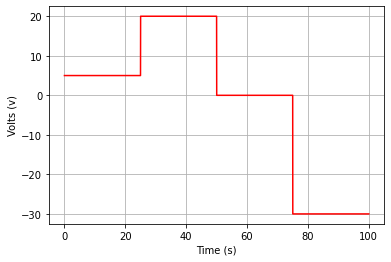

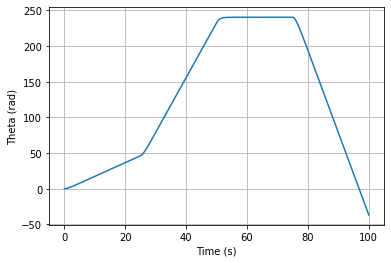

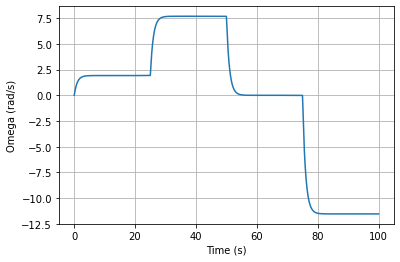

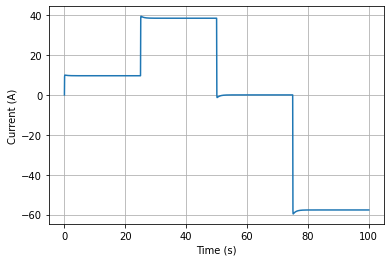

In [4]:
#Generating and visualizing training data 

#model constants
R,L,K,J,B = 0.5,1.2e-2,0.1,0.5 ,0.5

#inputs
temp = int(len(Time)/4)
U =  np.concatenate( (5*np.ones((temp,1)) ,20*np.ones((temp,1)) ,np.zeros((temp,1)) ,-30*np.ones((temp,1))) )
#U = 10*np.sin(0.05*Time)*np.sin(Time)
U = U.reshape(len(Time), 1 ) 
#plotting input 
plt.plot(Time,U,"r")
plt.xlabel("Time (s)")
plt.ylabel("Volts (v)")
plt.grid(1)
plt.show()

#state space matrices
A =  np.array([[0,  1,    0],
               [0,-B/J, K/J],
               [0,-K/L,-R/L]])
B = np.array([[0],
              [0],
              [1/L]])
C = np.eye(3)
D = np.zeros((3,1))

#running the model 
system = signal.lti(A,B,C,D)
_,Y, _ = signal.lsim2(system, U, Time)
#plotting system outputs
labels =['Theta (rad)','Omega (rad/s)',"Current (A)"]
for y,label in zip(Y.T,labels):
    plt.plot(Time,y)
    plt.xlabel("Time (s)")
    plt.ylabel(label)
    plt.grid(1)
    plt.show()

#preparing the data for identification Y shape :(len(time) +1<-- for initial conditions,-1) , U shape :(len(time),-1) 
ics = np.zeros((1,Y.shape[-1]))
Y = np.concatenate((ics,Y),axis=0).T
U = U.T

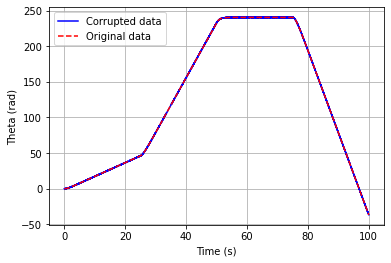

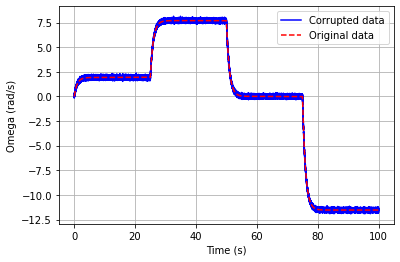

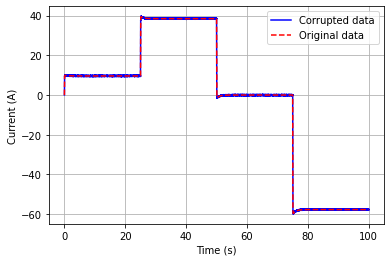

0 : cost = 0.0239906404167414  took:  0:00:04.475317
50 : cost = 0.0153684457764030  took:  0:00:00.149672
100 : cost = 0.0152058070525527  took:  0:00:00.144972
150 : cost = 0.0151470946148038  took:  0:00:00.137427
200 : cost = 0.0150911360979080  took:  0:00:00.139973
250 : cost = 0.0150349903851748  took:  0:00:00.135948
300 : cost = 0.0149801354855299  took:  0:00:00.142909
350 : cost = 0.0149280326440930  took:  0:00:00.143781
400 : cost = 0.0148796858265996  took:  0:00:00.139751
450 : cost = 0.0148357013240457  took:  0:00:00.143829
500 : cost = 0.0147963659837842  took:  0:00:00.146917
550 : cost = 0.0147617086768150  took:  0:00:00.138465
600 : cost = 0.0147315915673971  took:  0:00:00.142368
650 : cost = 0.0147057455033064  took:  0:00:00.137549
700 : cost = 0.0146838277578354  took:  0:00:00.153209
750 : cost = 0.0146654462441802  took:  0:00:00.140553
800 : cost = 0.0146501949056983  took:  0:00:00.137800
850 : cost = 0.0146376769989729  took:  0:00:00.139655
900 : cost = 

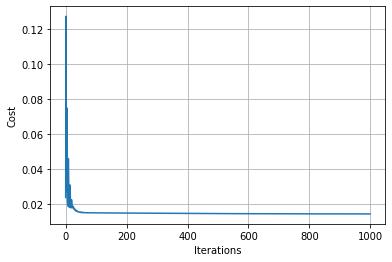

In [5]:
#Identification algorithm.
#in order to simulate real sensory data, we add some random noise to the data to see how the algorithm will handle it.   

iters = 1000
noise_levels = np.array([0.05,0.1,0.1]).reshape(3,-1)
lr = 2.5
noise  = np.random.randn(*Y.shape) * noise_levels
Yn= Y+ noise
for s,s_,label in zip(Y[:,1:],Yn[:,1:],labels):
    plt.plot(Time,s_,'b',label='Corrupted data')
    plt.plot(Time,s,'r--',label='Original data')
    plt.xlabel("Time (s)")
    plt.ylabel(label)
    plt.grid(1)
    plt.legend()
    plt.show()

#build the system identifier object
oshp,ishp = Y.shape[0], U.shape[0]
iden = SysIden(ishp,oshp,dt,lr)

iden.optimize(Yn,U,1000)



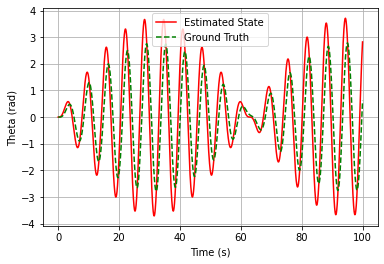

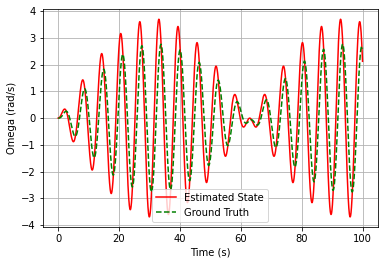

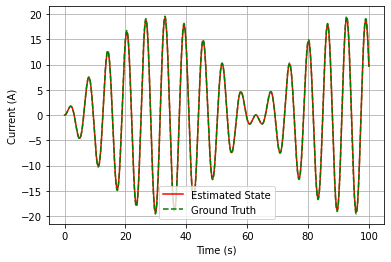

In [6]:
#Results Showing 
#Here, the identified matrices are used in a new state space system. please refer to paper to see
# the assumption made in the algorithm, this will explain how the new system is built -for C and D matrices-.
#then comparison is made with original system

temp = int(len(Time)/4)
#U =  np.concatenate( ([0],5*np.ones((temp-1,)) ,20*np.ones((temp,)) ,np.zeros((temp,)) ,-30*np.ones((temp,))) )
U = 10*np.sin(0.05*Time)*np.sin(Time)
U = U.reshape(len(Time), 1 ) #(length, no. of inputs, size of input)

A,B = iden.get_matrices()
C = np.eye(3)
D = np.zeros((3,1))
system1 = signal.lti(A,B,C,D)

_, X_new, _ = signal.lsim2(system1, U, Time)
_, X_old, _ = signal.lsim2(system, U, Time)

ploting1,ploting2 = X_old.T, X_new.T
for q,w,name in zip(ploting1,ploting2,labels):
  plt.plot(Time,w,'r', label='Estimated State')
  plt.plot(Time,q,'g--',label='Ground Truth')
  plt.xlabel("Time (s)")
  plt.ylabel(name)
  plt.legend()
  plt.grid(1)
  plt.show()

### assumption violating model 

This system is an interesting case. the characteristics of this model violates the assumptions used to build the identification algorithm -the state space model of the system has a C matrix that is not an identity-. Yet, the algorithm could identify the system.

This system has no physical meaning. It is just a mathematical representation of a hypothetical system.

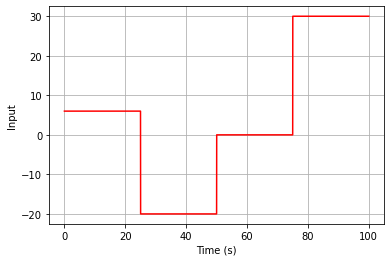

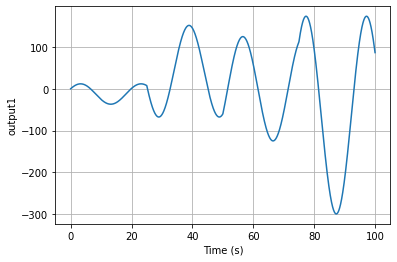

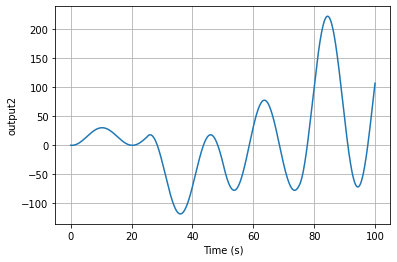

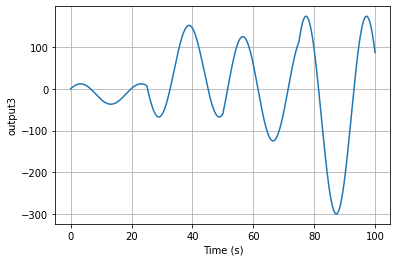

In [7]:
#inputs
temp = int(len(Time)/4)
U =  np.concatenate( (6*np.ones((temp,1)) ,-20*np.ones((temp,1)) ,np.zeros((temp,1)) ,30*np.ones((temp,1))) )
#U = 10*np.sin(0.05*Time)*np.sin(Time)
U = U.reshape(len(Time), 1 ) 
#plotting input 
plt.plot(Time,U,"r")
plt.xlabel("Time (s)")
plt.ylabel("Input")
plt.grid(1)
plt.show()

#state space matrices
A = np.array([[0,-0.2],[0.5,0]])
B = np.array([[5],[-1]])
C = np.array([[0.2,-0.1],[0,0.1],[0.2,-0.1]])
D = np.zeros((3,1))

#running the model 
system = signal.lti(A,B,C,D)
_,Y, _ = signal.lsim2(system, U, Time)
#plotting system outputs
labels = ['output1','output2','output3']
for y,label in zip(Y.T,labels):
    plt.plot(Time,y)
    plt.xlabel("Time (s)")
    plt.ylabel(label)
    plt.grid(1)
    plt.show()

#preparing the data for identification Y shape :(len(time) +1<-- for initial conditions,-1) , U shape :(len(time),-1) 
ics = np.zeros((1,Y.shape[-1]))
Y = np.concatenate((ics,Y),axis=0).T
U = U.T


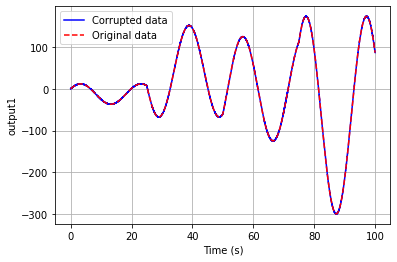

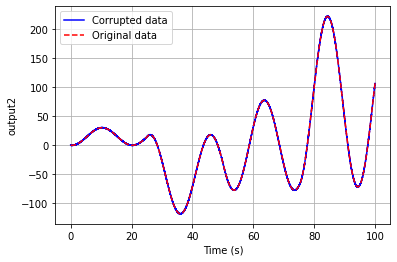

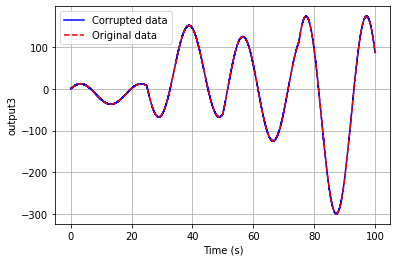

0 : cost = 0.0420707166194916  took:  0:00:00.029133
50 : cost = 0.0153944185003638  took:  0:00:00.138174
100 : cost = 0.0150697445496917  took:  0:00:00.144655
150 : cost = 0.0150665557011962  took:  0:00:00.139799
200 : cost = 0.0150659671053290  took:  0:00:00.139119
250 : cost = 0.0150652900338173  took:  0:00:00.136895
300 : cost = 0.0150645347312093  took:  0:00:00.136881
350 : cost = 0.0150636993348598  took:  0:00:00.147441
400 : cost = 0.0150627959519625  took:  0:00:00.144020
450 : cost = 0.0150618208572268  took:  0:00:00.132973
500 : cost = 0.0150607777759433  took:  0:00:00.133154
550 : cost = 0.0150596629828215  took:  0:00:00.128360
600 : cost = 0.0150584932416677  took:  0:00:00.133387
650 : cost = 0.0150572489947081  took:  0:00:00.136071
700 : cost = 0.0150559395551682  took:  0:00:00.137758
750 : cost = 0.0150545667856932  took:  0:00:00.136931
800 : cost = 0.0150531297549605  took:  0:00:00.131245
850 : cost = 0.0150516293942928  took:  0:00:00.127576
900 : cost = 

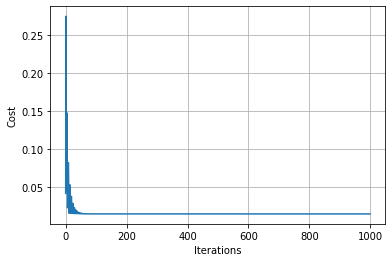

In [8]:
iters = 1000
noise_levels = np.array([0.05,0.1,0.1]).reshape(3,-1)
lr = 2.5
noise  = np.random.randn(*Y.shape) * noise_levels
Yn= Y+ noise
labels = ['output1','output2','output3']
for s,s_,label in zip(Y[:,1:],Yn[:,1:],labels):
    plt.plot(Time,s_,'b',label='Corrupted data')
    plt.plot(Time,s,'r--',label='Original data')
    plt.xlabel("Time (s)")
    plt.ylabel(label)
    plt.grid(1)
    plt.legend()
    plt.show()

#build the system identifier object
oshp,ishp = Y.shape[0], U.shape[0]
iden = SysIden(ishp,oshp,dt,lr)

iden.optimize(Yn,U,1000)

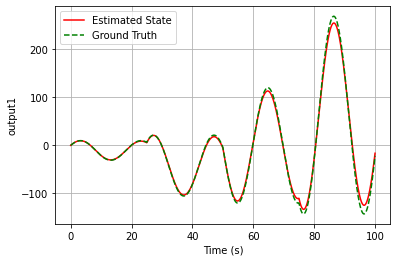

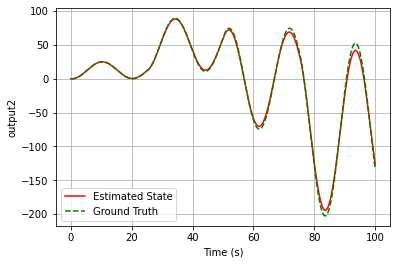

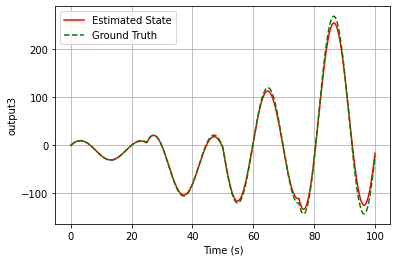

In [9]:
#Results Showing

temp = int(len(Time)/4)
U =  np.concatenate( ([[0]],5*np.ones((temp-1,1)) ,20*np.ones((temp,1)) ,np.zeros((temp,1)) ,-30*np.ones((temp,1))) )
#U = 10*np.sin(0.05*Time)*np.sin(Time)
#U = U.reshape(len(Time), 1 ) 

A,B = iden.get_matrices()
C = np.eye(3)
D = np.zeros((3,1))
system1 = signal.lti(A,B,C,D)

_, X_new, _ = signal.lsim2(system1, U, Time)
_, X_old, _ = signal.lsim2(system, U, Time)

ploting1,ploting2 = X_old.T, X_new.T

for q,w,name in zip(ploting1,ploting2,labels):
  plt.plot(Time,w,'r', label='Estimated State')
  plt.plot(Time,q,'g--',label='Ground Truth')
  plt.xlabel("Time (s)")
  plt.ylabel(name)
  plt.legend()
  plt.grid(1)
  plt.show()

### Mass, Spring, Damper

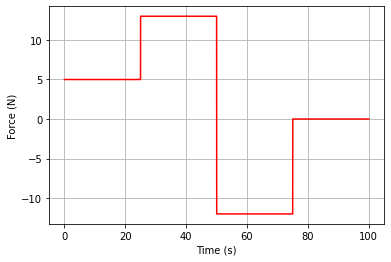

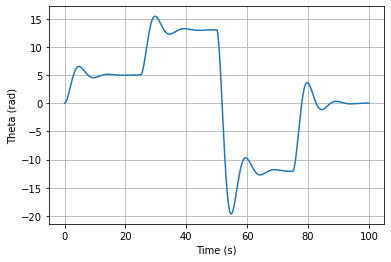

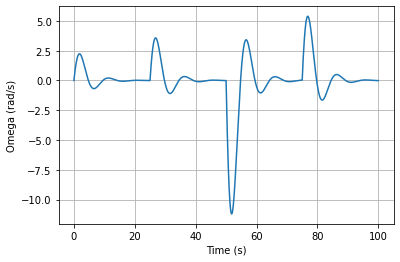

In [10]:
#same as previous

#parameters
k,b,m=1,1,2

#inputs
temp = int(len(Time)/4)
U =  np.concatenate( (5*np.ones((temp,)),13*np.ones((temp,)),-12*np.ones((temp,)) ,np.zeros((temp,))) )
#U = 10*np.sin(0.05*Time)*np.sin(Time)
U = U.reshape(len(Time), 1 ) 
#plotting input 
plt.plot(Time,U,"r")
plt.xlabel("Time (s)")
plt.ylabel("Force (N)")
plt.grid(1)
plt.show()

#state space matrices
A = np.array([[0,1],[-k/m,-b/m]])
B = np.array([[0],[1/m]])
C = np.eye(2)
D = np.zeros((2,1))

#running the model 
system = signal.lti(A,B,C,D)
_,Y, _ = signal.lsim2(system, U, Time)
#plotting system outputs
labels = ['Theta (rad)','Omega (rad/s)']
for y,label in zip(Y.T,labels):
    plt.plot(Time,y)
    plt.xlabel("Time (s)")
    plt.ylabel(label)
    plt.grid(1)
    plt.show()

#preparing the data for identification Y shape :(len(time) +1<-- for initial conditions,-1) , U shape :(len(time),-1) 
ics = np.zeros((1,Y.shape[-1]))
Y = np.concatenate((ics,Y),axis=0).T
U = U.T

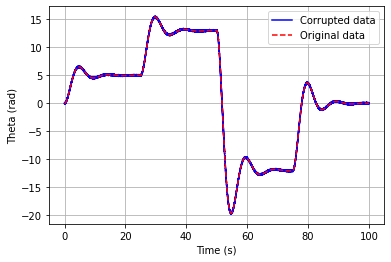

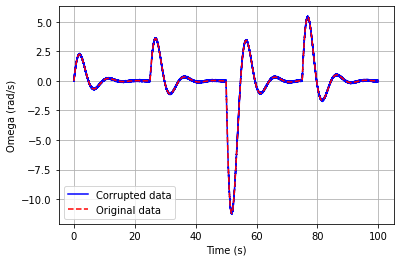

0 : cost = 0.0032359301112592  took:  0:00:00.028446
50 : cost = 0.0031197390053421  took:  0:00:00.113591
100 : cost = 0.0031168775167316  took:  0:00:00.116087
150 : cost = 0.0031166998669505  took:  0:00:00.110555
200 : cost = 0.0031166991684586  took:  0:00:00.114061
250 : cost = 0.0031166989356279  took:  0:00:00.123850
300 : cost = 0.0031166989356279  took:  0:00:00.114822
350 : cost = 0.0031166989356279  took:  0:00:00.110884
400 : cost = 0.0031166989356279  took:  0:00:00.111531
450 : cost = 0.0031166989356279  took:  0:00:00.114180
500 : cost = 0.0031166989356279  took:  0:00:00.113356
550 : cost = 0.0031166989356279  took:  0:00:00.109703
600 : cost = 0.0031166989356279  took:  0:00:00.114306
650 : cost = 0.0031166987027973  took:  0:00:00.111647
700 : cost = 0.0031166989356279  took:  0:00:00.122967
750 : cost = 0.0031166989356279  took:  0:00:00.109330
800 : cost = 0.0031166991684586  took:  0:00:00.113410
850 : cost = 0.0031166987027973  took:  0:00:00.129483
900 : cost = 

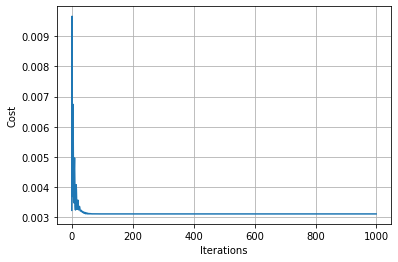

In [11]:
#Optimization Session (You would need to only edit epochs, noise level, Lr)  

iters = 1000
noise_levels = np.array([0.05,0.025]).reshape(2,-1)
lr = 5
noise  = np.random.randn(*Y.shape) * noise_levels
Yn= Y+ noise
for s,s_,label in zip(Y[:,1:],Yn[:,1:],labels):
    plt.plot(Time,s_,'b',label='Corrupted data')
    plt.plot(Time,s,'r--',label='Original data')
    plt.xlabel("Time (s)")
    plt.ylabel(label)
    plt.grid(1)
    plt.legend()
    plt.show()

#build the system identifier object
oshp,ishp = Y.shape[0], U.shape[0]
iden = SysIden(ishp,oshp,dt,lr)

iden.optimize(Yn,U,1000)

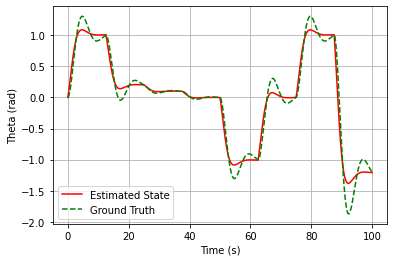

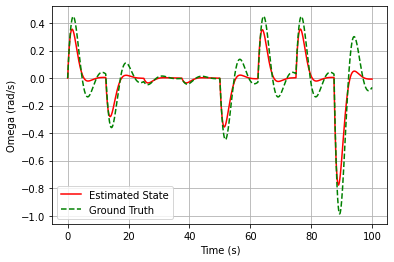

In [12]:
#Results Showing (you would only need to change the input vector)

temp = int(len(Time)/8)
U =  np.concatenate( (np.ones((temp,)),0.2*np.ones((temp,)),0.1*np.ones((temp,)) ,np.zeros((temp,)),-1*np.ones((temp,)),np.zeros((temp,)) ,1*np.ones((temp,)) ,-1.2*np.ones((temp,))) )
#U = 10*np.sin(0.05*Time)*np.sin(Time)
#U = U.reshape(len(Time), 1 ) 

A,B = iden.get_matrices()
C = np.eye(2)
D = np.zeros((2,1))
system1 = signal.lti(A,B,C,D)

_, X_new, _ = signal.lsim2(system1, U, Time)
_, X_old, _ = signal.lsim2(system, U, Time)

ploting1,ploting2 = X_old.T, X_new.T
for q,w,name in zip(ploting1,ploting2,labels):
  plt.plot(Time,w,'r', label='Estimated State')
  plt.plot(Time,q,'g--',label='Ground Truth')
  plt.xlabel("Time (s)")
  plt.ylabel(name)
  plt.legend()
  plt.grid(1)
  plt.show()